In [1]:
import os

import numpy as np

import torch
import torchvision
from torchvision.io import read_image
from torchvision.transforms import v2

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from piq import BRISQUELoss, TVLoss, brisque, ssim, psnr

import random


import matplotlib.pyplot as plt

from utils import loss_history, plot_history

from tqdm import tqdm

import json

import wandb

import kornia

from torch_trainer import torch_trainer
import data

import torchvision.models.swin_transformer as swin
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


%matplotlib inline

In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
class Config(dict):
    def __init__(self):
        super().__init__(
            dict(
                #input_path = "/kaggle/input/stanford-cars-dataset",
                #output_path = "/kaggle/working",
                #checkpoint_path = "mbr.pt",
                epochs = 100, 
                input_size = (3,64,64),
                hidden_dim=180,
                patch_size=4,
                num_heads=4,
                window_size=7,
                upsample = 2,
                #cpu_count = mp.cpu_count(),
                #gpu_count = torch.cuda.device_count() if torch.cuda.is_available() else 0,
                device = "cuda" if torch.cuda.is_available() else "cpu",
                num_workers=2,
                batch_size=1,
                #dist_enabled = True,
                #dist_worldsize = os.environ["DIST_WORLDSIZE"] if "DIST_WORLDSIZE" in os.environ else (torch.cuda.device_count() if torch.cuda.is_available() else 1), 
                #dist_port = os.environ["DIST_PORT"] if "DIST_PORT" in os.environ else 23456,
                #dist_hostname = os.environ["DIST_HOSTNAME"] if "DIST_HOSTNAME" in os.environ else "localhost",
                #rank = dist.get_rank() if dist.is_initialized() else None,
                #localrank = dist.get_rank() % torch.cuda.device_count() if (torch.cuda.is_available() and dist.is_initialized()) else 0
            )) 

In [4]:
class PatchUnembed(nn.Module):
    def forward(self, x):
        #print ('unemb ', x.shape)
        return x.permute(0,3,1,2)

class PatchEmbed(nn.Module):
    def forward(self, x):
        #print ('emb ', x.shape)
        return x.permute(0,2,3,1)


class RSTB(nn.Sequential):
    def __init__(self, config, sdp):
        super().__init__(
                *[swin.SwinTransformerBlockV2(
                    dim=config["hidden_dim"], num_heads=4, window_size=[config["window_size"]]*2,
                    shift_size=[0,0] if (i%2==0) else [config["window_size"]//2]*2,
                    stochastic_depth_prob=sdp[i]) for i in range(6)],
                PatchUnembed(),
                nn.Conv2d(config["hidden_dim"], config["hidden_dim"]//4, 3, padding=1),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(config["hidden_dim"]//4, config["hidden_dim"]//4, 1),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(config["hidden_dim"]//4, config["hidden_dim"],3,padding=1),
                PatchEmbed(),
        )


class SwinIR(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.config = config
        
        
        self.upscale = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bicubic'),
        )
        self.embed = nn.Sequential(
            nn.Conv2d(config["input_size"][0],config["hidden_dim"], 3, padding=1),
            PatchEmbed()
        )
        sdp = [v.item() for v in torch.linspace(0,0.2,36)]
        self.rstb_layers = nn.ModuleList(
            [RSTB(config, sdp[i*6:(i+1)*6]) for i in range(6)]
        )
        self.unembed = nn.Sequential(
            PatchUnembed(),
            nn.Conv2d(config["hidden_dim"],config["hidden_dim"]//4,3,padding=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(config["hidden_dim"]//4,config["hidden_dim"]//4,1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            #nn.Conv2d(config["hidden_dim"]//4, config["hidden_dim"], 3, padding=1),

            #nn.Conv2d(config["hidden_dim"], config["hidden_dim"], 3, padding=1),
            #nn.LeakyReLU(negative_slope=0.2, inplace=True),

            #nn.Conv2d(config['hidden_dim'], config["hidden_dim"]*4, 3, padding=1),
            #nn.PixelShuffle(2),
            #nn.Conv2d(config["hidden_dim"], config["hidden_dim"], 3, padding=1),
            #nn.LeakyReLU(negative_slope=0.2, inplace=True),

            #nn.Conv2d(config["hidden_dim"], config["hidden_dim"]*4, 3, padding=1),
            #nn.PixelShuffle(2),
            #nn.Conv2d(config["hidden_dim"], config["hidden_dim"], 3, padding=1),
            #nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(config["hidden_dim"]//4, config["input_size"][0], 3, padding=1)
        )


    def forward(self, x):
        #print('---', x.shape)
        x = self.upscale(x)
        y = self.embed(x)
        y0 = y
        for rstb in self.rstb_layers:
            y = rstb(y) + y
        y = y + y0
        #print(y.shape)
        return self.unembed(y) + x

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print (device) 

cuda


# patches

In [7]:
ds_realsr_lr_patches = data.data_patches_realsr_x2_train(patch_size=(64,64))
ds_train_patches, ds_val_patches = torch.utils.data.random_split(ds_realsr_lr_patches, [0.8, 0.2])

100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [01:12<00:00,  5.60it/s]


In [8]:
BATCH_SIZE = 1

dl_train_patches = DataLoader(ds_train_patches, batch_size=BATCH_SIZE, shuffle=True)
dl_val_patches = DataLoader(ds_val_patches, batch_size=1, shuffle=False)
dl_lr_patches = {'train': dl_train_patches, 'test': dl_val_patches}

In [9]:
def __compute_padding(kernel_size: list[int]) -> list[int]:
    """Compute padding tuple."""
    # from kornia lib
    # 4 or 6 ints:  (padding_left, padding_right,padding_top,padding_bottom)
    # https://pytorch.org/docs/stable/nn.html#torch.nn.functional.pad
    if len(kernel_size) < 2:
        raise AssertionError(kernel_size)
    computed = [k - 1 for k in kernel_size]

    # for even kernels we need to do asymmetric padding :(
    out_padding = 2 * len(kernel_size) * [0]

    for i in range(len(kernel_size)):
        computed_tmp = computed[-(i + 1)]

        pad_front = computed_tmp // 2
        pad_rear = computed_tmp - pad_front

        out_padding[2 * i + 0] = pad_front
        out_padding[2 * i + 1] = pad_rear
    return out_padding


def _hr2lr(img, kernel, factor=2.0):
    
    img_noised = img + torch.normal(0, 0.015, size=img.shape).to(img.device)

    b, c, h, w = img.shape

    kernel = kernel.expand(1,c,-1,-1)
    hk, wk = kernel.shape[-2:]
    kernel = kernel.reshape(-1, 1, hk, wk)

    padding_shape: list[int] = __compute_padding([hk, wk])

    img_pad = F.pad(img_noised, padding_shape, mode='reflect')
    img_pad = img_pad.view(-1, kernel.size(0), img_pad.size(-2), img_pad.size(-1))

    img_blur = F.conv2d(img_pad, kernel, groups=kernel.size(0), padding=0, stride=1)
    img_blur = img_blur.view(b, c, h, w)

    mode = random.choice(['bilinear', 'bicubic'])
    out = F.interpolate(
        img_blur,
        size=(h//factor, w//factor),
        mode=mode,
        align_corners=False,
    )
    
    return out

In [10]:
scale = 2

#kernel = torch.tensor(
#        [
#            [
#                [1.0, 4.0, 6.0, 4.0, 1.0],
#                [4.0, 16.0, 24.0, 16.0, 4.0],
#                [6.0, 24.0, 36.0, 24.0, 6.0],
#                [4.0, 16.0, 24.0, 16.0, 4.0],
#                [1.0, 4.0, 6.0, 4.0, 1.0],
#            ]
#        ]
#    )/ 256.0

kernel = torch.tensor(
        [
            [
                [1.0, 4.0, 6.0, 4.0, 1.0],
                [4.0, 16.0, 24.0, 16.0, 4.0],
                [6.0, 24.0, 36.0, 24.0, 6.0],
                [4.0, 16.0, 24.0, 16.0, 4.0],
                [1.0, 4.0, 6.0, 4.0, 1.0],
            ]
        ]
    )/ 256.0

kernel = kernel.to(device)

def loss_ssim_l2(y_pred, y_true, eps=1e-5):
    y_pred_down = _hr2lr(img=y_pred, kernel=kernel, factor=scale)  #kornia.geometry.pyrdown(y_pred)
    loss_ssim = kornia.losses.ssim_loss(y_pred_down, y_true, window_size=11, max_val=1.)
    loss_l2 = nn.MSELoss()(y_pred_down, y_true)
    loss_tv = kornia.losses.total_variation(y_pred, reduction='mean').sum()
    del y_true
    del y_pred_down
    torchvision.utils.save_image(y_pred[0], './run/v3_pred.png')
    del y_pred
    return 0.1*loss_l2 + 0.8*loss_ssim  + 0.1*loss_tv #+ 1./loss_tv


def metric_ssim(y_pred, y_true):
    y_pred_down = _hr2lr(img=y_pred, kernel=kernel, factor=scale)  #y_pred_down = rescale(y_pred, y_true)
    return kornia.metrics.ssim(y_pred_down, y_true, window_size=11, max_val=1.).mean()

torch.cuda.empty_cache()
#model = sr_from_lr(scale=scale, n_blocks=3, channels=256).to(device)

config = Config()
model = SwinIR(config)
#model = model.cuda()
print(model)

criterion = loss_ssim_l2
optimizer = torch.optim.Adamax(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=3,min_lr=1e-10)
trainer = torch_trainer(model=model,
                       criterion=criterion,
                       optimizer=optimizer,
                       scheduler=scheduler, 
                       epochs=20,
                       dataloader=dl_lr_patches)
trainer.set_metrics(metric_name='SSIM', metric_function=metric_ssim)
#trainer.wandb_log(True)

#run = wandb.init(project='itmo blind superresolution', 
#                 group='v2_realsr_zssr', 
#                 job_type='train')
#wandb.watch(model, criterion, log="all", log_freq=10)

history = trainer.train()

SwinIR(
  (upscale): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bicubic')
  )
  (embed): Sequential(
    (0): Conv2d(3, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PatchEmbed()
  )
  (rstb_layers): ModuleList(
    (0): RSTB(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((180,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=180, out_features=540, bias=True)
          (proj): Linear(in_features=180, out_features=180, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=4, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((180,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=180, out_features=720, bias=True)
      

epoch 1/20...  train/loss: 0.0431 val/loss: 0.0158 lr: 0.001 metric/SSIM: 0.9850; time: 000:10:12
epoch 2/20...  train/loss: 0.0163 val/loss: 0.0154 lr: 0.001 metric/SSIM: 0.9860; time: 000:08:53
epoch 3/20...  train/loss: 0.0154 val/loss: 0.0151 lr: 0.001 metric/SSIM: 0.9862; time: 000:08:26
epoch 4/20...  train/loss: 0.0150 val/loss: 0.0150 lr: 0.001 metric/SSIM: 0.9864; time: 000:09:02
epoch 5/20...  train/loss: 0.0152 val/loss: 0.0151 lr: 0.001 metric/SSIM: 0.9865; time: 000:11:59
epoch 6/20...  train/loss: 0.0159 val/loss: 0.0154 lr: 0.001 metric/SSIM: 0.9865; time: 000:09:48
epoch 7/20...  train/loss: 0.0152 val/loss: 0.0171 lr: 0.001 metric/SSIM: 0.9819; time: 000:09:44
epoch 8/20...  train/loss: 0.0154 val/loss: 0.0148 lr: 0.0005 metric/SSIM: 0.9878; time: 000:09:53
epoch 9/20...  train/loss: 0.0144 val/loss: 0.0150 lr: 0.0005 metric/SSIM: 0.9877; time: 000:10:29
epoch 10/20...  train/loss: 0.0141 val/loss: 0.0146 lr: 0.0005 metric/SSIM: 0.9892; time: 000:08:38
epoch 11/20...  

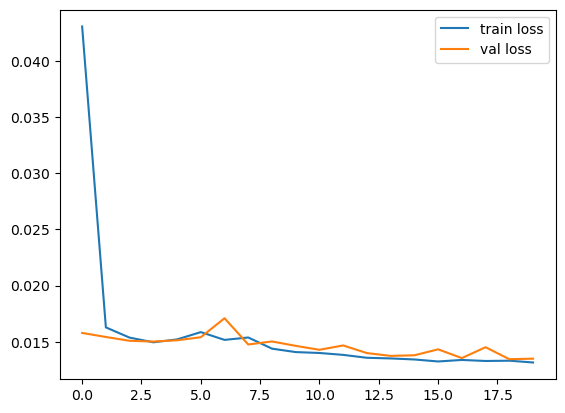

In [11]:
trainer.history.plot()

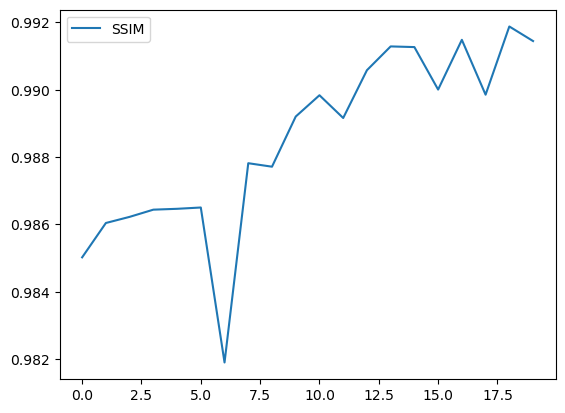

In [12]:
trainer.history.plot(train=False, val=False, metric='SSIM')

In [13]:
def plot_results(img_lr, img_reconstructed, img_gt):
    img_lr_resized = kornia.geometry.resize(img_lr, (img_reconstructed.shape[1],
                                                     img_reconstructed.shape[2]), interpolation='bicubic', antialias=True)
    ssim_lr = kornia.metrics.ssim(img1=img_lr_resized[None,:], img2=img_gt[None,:], window_size=11).mean()
    ssim_reconstructed = kornia.metrics.ssim(img_reconstructed[None,:], img_gt[None,:], window_size=11).mean()
    plt.subplots(1,3, figsize=(15,10))
    plt.subplot(1,3,1)
    plt.imshow(img_gt.permute(1,2,0))
    plt.title(f'hr ground true')
    plt.subplot(1,3,2)
    plt.imshow(img_lr_resized.permute(1,2,0))
    plt.title(f'bicubic, SSIM={ssim_lr:.4f}')
    plt.subplot(1,3,3)
    plt.imshow(img_reconstructed.permute(1,2,0))
    plt.title(f'reconstructed, SSIM={ssim_reconstructed:.4f}')

In [14]:
torch.save(model.state_dict(), 'swin_2_180_64x64_20ep_08ssim_01l2_01tv_noise0015_randomMode.pt')

In [ ]:
#model = sr_from_lr(scale=2, n_blocks=5, channels=128).to(device)
#model.load_state_dict(torch.load('cnn_256_11blocks_128_20ep_08ssim_01l2_01tv_pyrdown.pt'))
#model.eval()
#print(model)

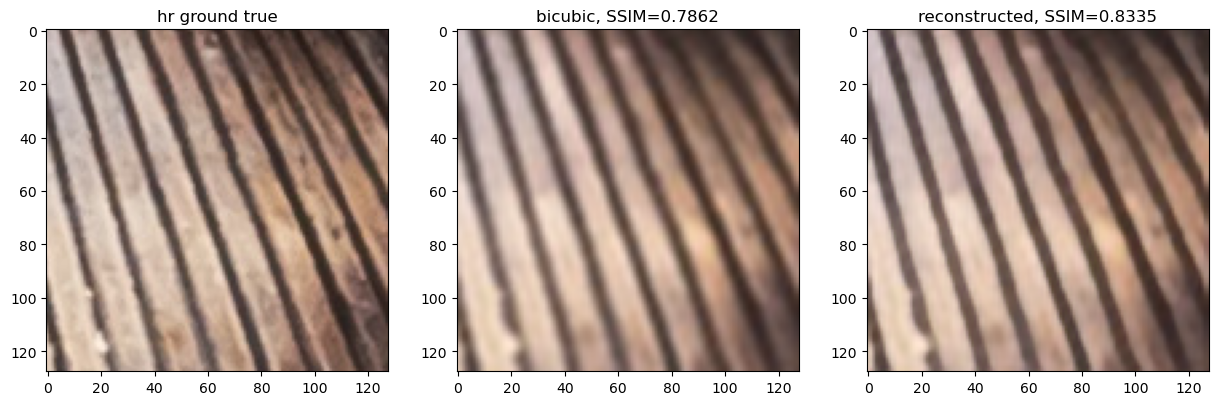

In [15]:
n = 55
torch.cuda.empty_cache()
device_ = 'cuda'
img_lr = ds_train_patches.dataset.images_source_patches[n]
img_ref = ds_train_patches.dataset.images_ref_patches[n]
model.eval()
with torch.no_grad():
    model = model.to(device_)
    img_reconstructed = model(img_lr[None,:].to(device_))[0].detach().cpu()
plot_results(img_lr, img_reconstructed, img_ref)
torchvision.utils.save_image(img_lr, 'v3_in.png')
torchvision.utils.save_image(img_reconstructed, 'v3_out.png')
torchvision.utils.save_image(img_ref, 'v3_ref.png')

In [17]:
data_set5 = data.image_dataset_patches_from_file(source_path = './data/benchmark/Set5/LR_bicubic/X2',
                                                 target_path = './data/benchmark/Set5/LR_bicubic/X2',
                                                 ref_path = './data/benchmark/Set5/HR',
                                                 patch_size = (64,64))

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 294.24it/s]


In [19]:
data_urban100 = data.image_dataset_patches_from_file(source_path = './data/benchmark/Urban100/LR_bicubic/X2',
                                                 target_path = './data/benchmark/Urban100/HR',
                                                 ref_path = './data/benchmark/Urban100/HR',
                                                 patch_size = (64,64))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 91.49it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


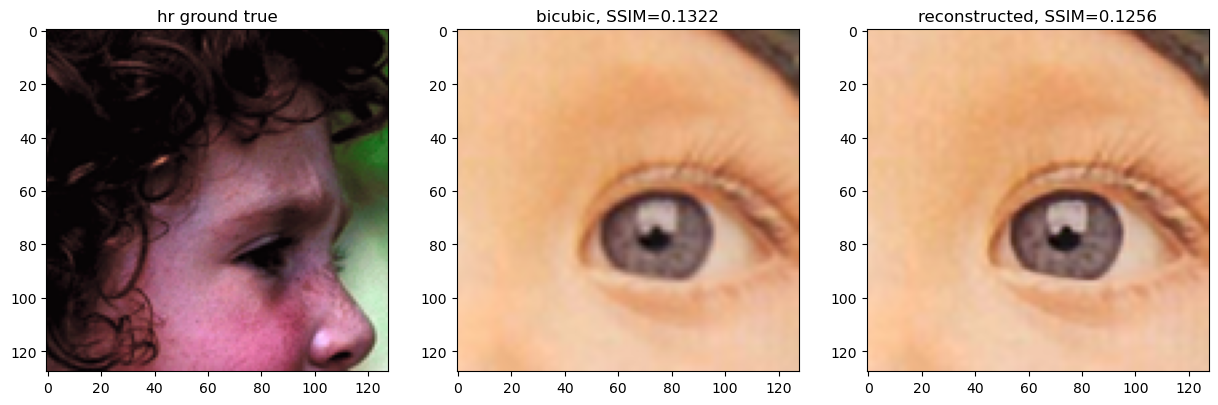

In [24]:
n = 6
torch.cuda.empty_cache()
device_ = 'cuda'
img_lr = data_set5.images_source_patches[n]
img_ref = data_set5.images_ref_patches[n]
model.eval()
with torch.no_grad():
    model = model.to(device_)
    img_reconstructed = model(img_lr[None,:].to(device_))[0].detach().cpu()
plot_results(img_lr, img_reconstructed, img_ref)
torchvision.utils.save_image(img_lr, 'v3_swin_set5_in.png')
torchvision.utils.save_image(img_reconstructed, 'v3_swin_set5_out.png')
torchvision.utils.save_image(img_ref, 'v3_swin_set5_ref.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


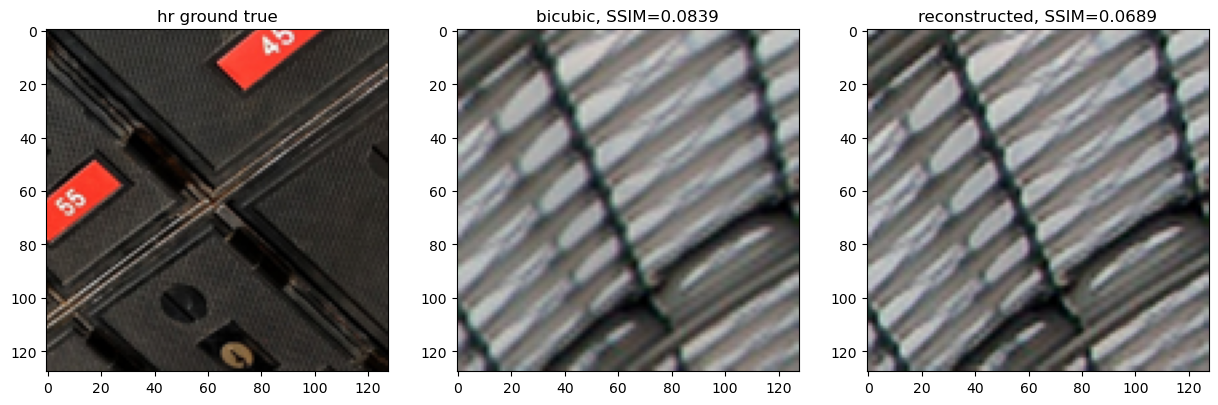

In [26]:
n = 55
torch.cuda.empty_cache()
device_ = 'cuda'
img_lr = data_urban100.images_source_patches[n]
img_ref = data_urban100.images_ref_patches[n]
model.eval()
with torch.no_grad():
    model = model.to(device_)
    img_reconstructed = model(img_lr[None,:].to(device_))[0].detach().cpu()
plot_results(img_lr, img_reconstructed, img_ref)
torchvision.utils.save_image(img_lr, 'v3_swin_set5_in.png')
torchvision.utils.save_image(img_reconstructed, 'v3_swin_set5_out.png')
torchvision.utils.save_image(img_ref, 'v3_swin_set5_ref.png')